Cross-val ROC-AUC scores: [0.67120059 0.72402597 0.69159686 0.67769822 0.69049584]
Mean CV ROC-AUC: 0.6910034992318306

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       423
           1       0.69      0.77      0.73       577

    accuracy                           0.67      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.67      0.67      0.67      1000

Test ROC-AUC: 0.7184876531828853


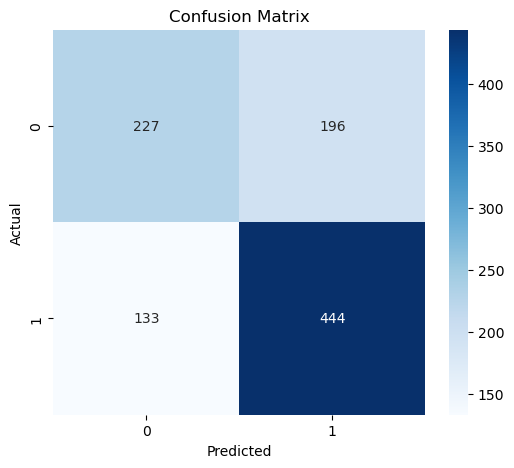


Top Feature Importances:
 last_purchase_days    0.233249
tenure_months         0.124378
total_spent_12m       0.120940
visits_per_month      0.119544
avg_order_value       0.118292
age                   0.100535
purchases_6m          0.062541
responded_to_promo    0.042504
region_East           0.013265
gender_Female         0.012417
region_West           0.012052
region_South          0.012023
gender_Male           0.011859
region_North          0.011784
gender_Other          0.004617
dtype: float64


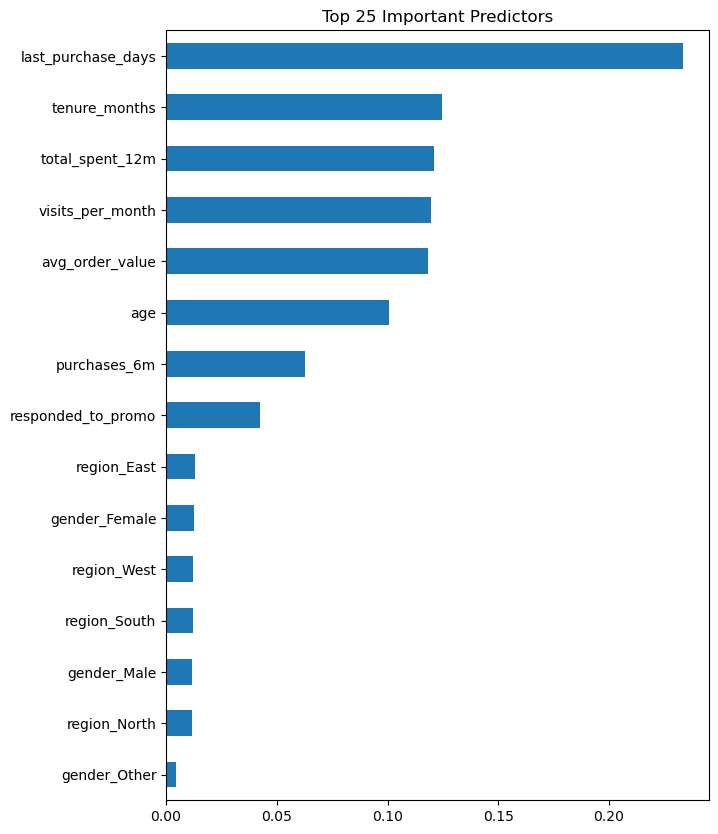


Model saved as retail_churn_model_pipeline.pkl


In [1]:
# retail_churn_train_clean.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Load dataset
df = pd.read_csv("retail_churn_dataset.csv")

# 2. Define target and features
target = "churn"
id_col = "customer_id"
X = df.drop(columns=[target, id_col])
y = df[target]

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Preprocessing
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# 5. Model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=250,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

# 6. Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print("Cross-val ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

# 7. Train final model
model.fit(X_train, y_train)

# 8. Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Feature importance (top 25)
clf = model.named_steps["clf"]
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["ohe"]
cat_cols = ohe.get_feature_names_out(categorical_features) if len(categorical_features) > 0 else []
feat_names = numeric_features + list(cat_cols)

importances = clf.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(25)
print("\nTop Feature Importances:\n", fi)

plt.figure(figsize=(7, 10))
fi.plot(kind="barh")
plt.title("Top 25 Important Predictors")
plt.gca().invert_yaxis()
plt.show()

# 10. Save model
joblib.dump(model, "retail_churn_model_pipeline.pkl")
print("\nModel saved as retail_churn_model_pipeline.pkl")
